<a href="https://colab.research.google.com/github/OrJaku/road-sign-recognition/blob/master/road_sign_rec_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd drive/My\ Drive/Colab Notebooks/Road_sign_rec

/content/drive/My Drive/Colab Notebooks/Road_sign_rec


In [0]:
import os, shutil, cv2

### Przygotowanie folderów

In [0]:
base_dir = "Data/"
train_dir = os.path.join(base_dir, 'train_data')
try:
  os.mkdir(train_dir)
except FileExistsError:
  pass


cross_train =  os.path.join(train_dir, 'cross')
stop_train =  os.path.join(train_dir, 'stop')
limit50_train =  os.path.join(train_dir, 'limit50')

try:
  os.mkdir(cross_train)
  os.mkdir(stop_train)
  os.mkdir(limit50_train)
except FileExistsError:
  pass

valid_dir = os.path.join(base_dir, 'valid_data')
try:
  os.mkdir(valid_dir)
except FileExistsError:
  pass

cross_val =  os.path.join(valid_dir, 'cross')
stop_val =  os.path.join(valid_dir, 'stop')
limit50_val =  os.path.join(valid_dir, 'limit50')

try:
  os.mkdir(cross_val)
  os.mkdir(stop_val)
  os.mkdir(limit50_val)
except FileExistsError:
  pass

test_dir = os.path.join(base_dir, 'test_data')
try:
  os.mkdir(test_dir)
except FileExistsError:
  pass

cross_test =  os.path.join(test_dir, 'cross')
stop_test =  os.path.join(test_dir, 'stop')
limit50_test =  os.path.join(test_dir, 'limit50')

try:
  os.mkdir(cross_test)
  os.mkdir(stop_test)
  os.mkdir(limit50_test)
except FileExistsError:
  pass



#### Ilość poszczegónych zdjęć

In [43]:
cross_origin_path = os.path.abspath("Data/information--pedestrians-crossing--g1/")
stop_origin_path = os.path.abspath("Data/regulatory--stop--g1")
limit50_origin_path = os.path.abspath("Data/regulatory--maximum-speed-limit-50--g1")

print('Przejscie dla piszych: ',len(os.listdir(cross_origin_path)))
print('Stop: ', len(os.listdir(stop_origin_path)))
print('Ograniczenie do 50km/h', len(os.listdir(limit50_origin_path)))

Przejscie dla piszych:  2188
Stop:  1368
Ograniczenie do 50km/h 711


#### Kopiowanie danych 

---



In [0]:

# train cross
for image_name in os.listdir(cross_origin_path)[0:1200]:
  src = os.path.join(cross_origin_path, image_name)
  dst = os.path.join(cross_train, image_name)
  shutil.copyfile(src, dst)
print("train cross copied")

# validation cross
for image_name in os.listdir(cross_origin_path)[1200:1800]:
  src = os.path.join(cross_origin_path, image_name)
  dst = os.path.join(cross_val, image_name)
  shutil.copyfile(src, dst)
print("validation cross copied")

# test cross
for image_name in os.listdir(cross_origin_path)[1800:]:
  src = os.path.join(cross_origin_path, image_name)
  dst = os.path.join(cross_test, image_name)
  shutil.copyfile(src, dst)
print("test cross copied")

##################################

# train stop
i=0
for image_name in os.listdir(stop_origin_path)[0:900]:
  i =+ 1
  src = os.path.join(stop_origin_path, image_name)
  dst = os.path.join(stop_train, image_name)
  shutil.copyfile(src, dst)
  if i == 200 or i == 400 or i == 700:
    print(f"Copied {i} ")
print("train stop copied")


# validation stop
for image_name in os.listdir(stop_origin_path)[901:1200]:
  src = os.path.join(stop_origin_path, image_name)
  dst = os.path.join(stop_val, image_name)
  shutil.copyfile(src, dst)
  if i == 1050:
    print(f"Copied {i} ")
print("validation stop copied")

# test stop
for image_name in os.listdir(stop_origin_path)[1201:]:
  src = os.path.join(stop_origin_path, image_name)
  dst = os.path.join(stop_test, image_name)
  shutil.copyfile(src, dst)
  if i == 1300:
    print(f"Copied {i} ")
print("test stop copied")


##########################

# train limit50
for image_name in os.listdir(limit50_origin_path)[0:400]:
  src = os.path.join(limit50_origin_path, image_name)
  dst = os.path.join(limit50_train, image_name)
  shutil.copyfile(src, dst)
print("train limit50 copied")

# validation limit50
for image_name in os.listdir(limit50_origin_path)[400:600]:
  src = os.path.join(limit50_origin_path, image_name)
  dst = os.path.join(limit50_val, image_name)
  shutil.copyfile(src, dst)
print("validation limit50 copied")

# test limit50
for image_name in os.listdir(limit50_origin_path)[600:]:
  src = os.path.join(limit50_origin_path, image_name)
  dst = os.path.join(limit50_test, image_name)
  shutil.copyfile(src, dst)
print("test limit50 copied")


#### Przekształcanie plików .jpg na tensory

In [22]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

picture_size = 100

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(picture_size,picture_size),
    batch_size=10,
    class_mode='categorical'

)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(picture_size,picture_size),
    batch_size=10,
    class_mode='categorical'

)
numer_of_classes = len(train_generator.class_indices)

Found 2500 images belonging to 3 classes.
Found 1099 images belonging to 3 classes.


In [0]:
import pandas as pd
import numpy as np
from keras import layers, models, optimizers

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 


##Model

In [131]:

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(picture_size, picture_size, 3)))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(numer_of_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['acc']
    )
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 128)      

In [132]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=25,
    validation_data=valid_generator,
    validation_steps=10
)

Epoch 1/25
100/100 [==============================] - 2s 25ms/step - loss: 0.4593 - acc: 0.8270 - val_loss: 0.2472 - val_acc: 0.9500
Epoch 2/25
100/100 [==============================] - 2s 22ms/step - loss: 0.1397 - acc: 0.9580 - val_loss: 0.0733 - val_acc: 0.9500
Epoch 3/25
100/100 [==============================] - 2s 24ms/step - loss: 0.1647 - acc: 0.9510 - val_loss: 0.0849 - val_acc: 1.0000
Epoch 4/25
100/100 [==============================] - 2s 22ms/step - loss: 0.0984 - acc: 0.9660 - val_loss: 0.0461 - val_acc: 0.9900
Epoch 5/25
100/100 [==============================] - 2s 23ms/step - loss: 0.0660 - acc: 0.9780 - val_loss: 0.0449 - val_acc: 0.9900
Epoch 6/25
100/100 [==============================] - 2s 23ms/step - loss: 0.0773 - acc: 0.9720 - val_loss: 0.0028 - val_acc: 0.9800
Epoch 7/25
100/100 [==============================] - 2s 22ms/step - loss: 0.0918 - acc: 0.9730 - val_loss: 0.0426 - val_acc: 0.9500
Epoch 8/25
100/100 [==============================] - 2s 23ms/step - 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


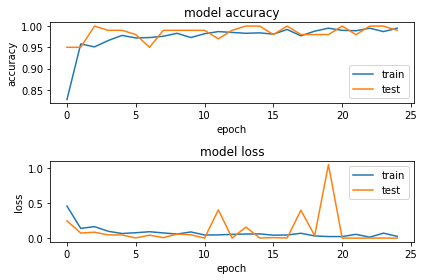

In [134]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [0]:
model_name = 'model_signs.h5'
model_path = os.path.join(base_dir, model_name)
model.save(model_path)

In [135]:
os.listdir(test_dir)

['cross', 'stop', 'limit50']

In [0]:
# to_del = os.path.join(test_dir, '.ipynb_checkpoints')
# os.rmdir(to_del)

In [83]:
pwd

'/content/drive/My Drive/Colab Notebooks/Road_sign_rec'

In [88]:
# !mv Data/test_data/stop Data/test_data/stop1 
# !mv Data/test_data/cross Data/test_data/stop 
# !mv Data/test_data/stop1 Data/test_data/cross 


mv: cannot stat 'Data/test_data/stop': No such file or directory


In [136]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(picture_size, picture_size),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
classes_gen = test_generator.class_indices
classes_gen

Found 666 images belonging to 3 classes.


{'cross': 0, 'limit50': 1, 'stop': 2}

In [0]:
predict = model.predict_generator(test_generator,steps = len(filenames))

In [138]:
loss_acc = model.evaluate(test_generator)
print('loss= ', loss_acc[0])
print("acc= ", loss_acc[1])

666/666 [==============================] - 2s 4ms/step
loss=  0.0
acc=  0.9954954981803894


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


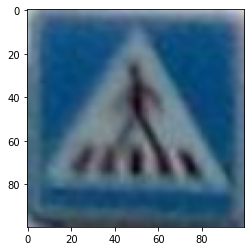

In [139]:
figure = plt.figure()
files = os.path.join(test_dir, 'cross')
test_files = os.listdir(files)

path_to_test = os.path.join(files, test_files[100])
img = cv2.imread(path_to_test)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(picture_size,picture_size))
plt.imshow(img)
plt.show()
figure

In [140]:
import matplotlib.pyplot as plt
signs = ['limit50', 'stop', 'cross']

fig = plt.figure()

for sign in signs:
  files = os.path.join(test_dir, sign)
  test_files = os.listdir(files)
  incorrect = 0
  for f in test_files:
    path_to_test = os.path.join(files, f)
    img = cv2.imread(path_to_test)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img,(picture_size,picture_size))
    img = img.astype("float32") / 255
    if incorrect == 2:
      plt.imshow(img)
      plt.show()

    img_tensor = np.reshape(img,[1,picture_size,picture_size,3])
    classes = (model.predict_classes(img_tensor)).tolist()
    # print(classes)
    if classes[0] == 0:
      classes = 'cross'
    
    elif classes[0] == 2:
      classes = 'stop'

    elif classes[0] == 1:
      classes = 'limit50'

    else:
      classes

    if classes != sign:
      incorrect += 1 
      plt.imshow(img)

  print(f'{sign}: {incorrect} / {len(test_files)},  Correct: {round(100-(incorrect/len(test_files)*100))}%')

  fig


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


limit50: 2 / 111,  Correct: 98%
stop: 1 / 167,  Correct: 99%
cross: 3 / 388,  Correct: 99%
